In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


# Data Preprocessing


In [ ]:
!unzip "/content/preprocessed.zip"

Archive:  /content/preprocessed.zip
   creating: preprocessed/
   creating: preprocessed/0_degrees/
  inflating: preprocessed/0_degrees/005227.jpg  
  inflating: preprocessed/0_degrees/007209.jpg  
  inflating: preprocessed/0_degrees/006748.jpg  
  inflating: preprocessed/0_degrees/000921.jpg  
  inflating: preprocessed/0_degrees/007463.jpg  
  inflating: preprocessed/0_degrees/005864.jpg  
  inflating: preprocessed/0_degrees/000161.jpg  
  inflating: preprocessed/0_degrees/007421.jpg  
  inflating: preprocessed/0_degrees/005863.jpg  
  inflating: preprocessed/0_degrees/003857.jpg  
  inflating: preprocessed/0_degrees/001443.jpg  
  inflating: preprocessed/0_degrees/003271.jpg  
  inflating: preprocessed/0_degrees/004962.jpg  
  inflating: preprocessed/0_degrees/002872.jpg  
  inflating: preprocessed/0_degrees/005441.jpg  
  inflating: preprocessed/0_degrees/006912.jpg  
  inflating: preprocessed/0_degrees/000491.jpg  
  inflating: preprocessed/0_degrees/000283.jpg  
  inflating: prepr

In [ ]:
import tensorflow as tf
import pathlib

# Specify the path to your local data directory
local_data_dir = '/content/preprocessed'

# Create a Path object for the data directory
data_dir = pathlib.Path(local_data_dir)

# Print the data directory path to verify
print(data_dir)

/content/preprocessed


In [ ]:
# config = [
#     {
#         "model_name": "ResNet50",
#         "learning_rate": 0.001,
#         "epochs": 15,
#         "data_augmentation": False,
#         "img_height": 224,
#         "img_width": 224,
#         "batch_size": 32,
#     },
#     {
#         "model_name": "ResNet50",
#         "learning_rate": 0.001,
#         "epochs": 15,
#         "data_augmentation": True,
#         "img_height": 224,
#         "img_width": 224,
#         "batch_size": 32,
#     },
#     {
#         "model_name": "InceptionV3",
#         "learning_rate": 0.0001,
#         "epochs": 15,
#         "data_augmentation": False,
#         "img_height": 299,
#         "img_width": 299,
#         "batch_size": 32,
#     },
#     {
#         "model_name": "VGG16",
#         "learning_rate": 0.001,
#         "epochs": 15,
#         "data_augmentation": False,
#         "img_height": 224,
#         "img_width": 224,
#         "batch_size": 32,
#     },
# ]

config = [
    {
        "model_name": "ResNet50",
        "learning_rate": 0.001,
        "epochs": 20,
        "data_augmentation": False,
        "img_height": 224,
        "img_width": 224,
        "batch_size": 32,
    },
    {
        "model_name": "InceptionV3",
        "learning_rate": 0.0001,
        "epochs": 20,
        "data_augmentation": False,
        "img_height": 299,
        "img_width": 299,
        "batch_size": 32,
    },
    {
        "model_name": "VGG16",
        "learning_rate": 0.001,
        "epochs": 20,
        "data_augmentation": False,
        "img_height": 224,
        "img_width": 224,
        "batch_size": 32,
    },
]



/content/preprocessed/0_degrees/005514.jpg


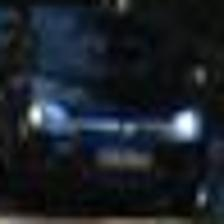

In [ ]:
zero_degrees = list(data_dir.glob('0_degrees/*'))
print(zero_degrees[0])
PIL.Image.open(str(zero_degrees[0]))

Data split

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

def setup_datasets_and_augmentation(config):
    # Load datasets
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        data_dir,
        validation_split=0.2,
        subset="training",
        seed=123,
        image_size=(config['img_height'], config['img_width']),
        batch_size=config['batch_size'],
        label_mode='categorical'
    )

    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        data_dir,
        validation_split=0.2,
        subset="validation",
        seed=123,
        image_size=(config['img_height'], config['img_width']),
        batch_size=config['batch_size'],
        label_mode='categorical'
    )

    # Print number of batches and batch size, total examples
    print(f"Training dataset batches: {len(train_ds)}")
    print(f"Validation dataset batches: {len(val_ds)}")
    print(f"Total training examples: {len(train_ds) * config['batch_size']}")
    print(f"Total validation examples: {len(val_ds) * config['batch_size']}")



    # Setup data augmentation if enabled
    if config['data_augmentation']:
        data_augmentation = Sequential([
            layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(config['img_height'], config['img_width'], 3)),
            layers.experimental.preprocessing.RandomRotation(0.1),  # Small rotations
            layers.experimental.preprocessing.RandomZoom(0.1),  # Small zoom
            layers.experimental.preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1)  # Moderate translation
        ])
        train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

    return train_ds, val_ds




In [ ]:
import io
import sklearn.metrics
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.callbacks import LambdaCallback


def log_images(epoch, logs):
    # Fetch a batch of images from the training dataset
    for image_batch, label_batch in train_ds.take(1):  # Take one batch
        tf.summary.image("Training data", image_batch, max_outputs=12, step=epoch)


def plot_to_image(figure):
    """Converts the matplotlib plot specified by 'figure' to a PNG image and returns it."""
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    plt.close(figure)
    buf.seek(0)
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    image = tf.expand_dims(image, 0)
    return image

def log_confusion_matrix(epoch, logs):
    # Use the model to predict the values from the validation dataset.
    test_pred_raw = model.predict(val_ds)
    test_pred = np.argmax(test_pred_raw, axis=1)

    # Calculate the confusion matrix using sklearn.metrics
    test_labels = np.concatenate([y for x, y in val_ds], axis=0)
    cm = sklearn.metrics.confusion_matrix(test_labels, test_pred)
    figure = plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    cm_image = plot_to_image(figure)

    # Log the confusion matrix as an image summary.
    with file_writer_cm.as_default():
        tf.summary.image("Confusion Matrix", cm_image, step=epoch)




# Train Model


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
import datetime

def setup_model(cfg):
    # Dynamic import based on the model name
    if cfg['model_name'] == 'ResNet50':
        from tensorflow.keras.applications import ResNet50 as Model
    elif cfg['model_name'] == 'InceptionV3':
        from tensorflow.keras.applications import InceptionV3 as Model
    elif cfg['model_name'] == 'VGG16':
        from tensorflow.keras.applications import VGG16 as Model

    base_model = Model(include_top=False, weights='imagenet',
                       input_shape=(cfg['img_height'], cfg['img_width'], 3), pooling='avg')
    base_model.trainable = False  # Freeze the base model

    model = Sequential([
        base_model,
        Flatten(),
        Dense(512, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.5),
        Dense(12, activation='softmax')  # Assuming there are 12 classes
    ])

    return model


def unfreeze_model(model, layers_to_unfreeze):
    # Unfreeze the top layers of the model
    for layer in model.layers[-layers_to_unfreeze:]:
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = True

def train_model(cfg, train_ds, val_ds):
    model = setup_model(cfg)
    model.compile(
        optimizer=Adam(learning_rate=cfg['learning_rate']),
        loss='categorical_crossentropy',
        metrics=['accuracy'])

    model.summary()

    # Setup TensorBoard logging
    log_dir = f"logs/{cfg['model_name']}_aug_{cfg['data_augmentation']}_lr_{cfg['learning_rate']}/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1, write_images=True)
    image_logging_callback = LambdaCallback(on_epoch_end=log_images)

    # Setup the file writer for the confusion matrix.
    file_writer_cm = tf.summary.create_file_writer(log_dir + '/cm')
    confusion_matrix_callback = LambdaCallback(on_epoch_end=log_confusion_matrix)


    # Set up the ModelCheckpoint callback to save the best model based on validation loss
    checkpoint_path = f"{cfg['model_name']}_best_model_exp2.h5"
    checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)

    # Train the model with frozen layers
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=5,  # Initial training period with frozen base model
        callbacks=[checkpoint, tensorboard_callback]
    )

    # Unfreeze some layers for fine-tuning
    unfreeze_model(model, layers_to_unfreeze=5)
    model.compile(
        optimizer=Adam(learning_rate=cfg['learning_rate'] * 0.1),  # Lower learning rate for fine-tuning
        loss='categorical_crossentropy',
        metrics=['accuracy'])

    # Continue training to fine-tune the unfrozen layers
    fine_tune_history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=cfg['epochs'] - 5,  # Continue training for the rest of the epochs
        callbacks=[checkpoint, tensorboard_callback, image_logging_callback, confusion_matrix_callback]
        )

    return model, history


In [ ]:
for cfg in config:
    print(f"Setting up datasets for {cfg['model_name']} with augmentation: {cfg['data_augmentation']}")
    train_ds, val_ds = setup_datasets_and_augmentation(cfg)

    model, history = train_model(cfg, train_ds, val_ds)
    # save the model or its weights after training
    model.save(f"saved_models/{cfg['model_name']}_model_exp2.h5")

# Model Performance


In [ ]:
!unzip "/content/Logs-20240419T063008Z-001.zip"

In [ ]:
!unzip "/content/saved_models-20240419T063014Z-001.zip"

Archive:  /content/saved_models-20240419T063014Z-001.zip
  inflating: saved_models/VGG16_model_exp2.h5  
  inflating: saved_models/InceptionV3_model_exp2.h5  
  inflating: saved_models/ResNet50_model_exp2.h5  


In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

# Start TensorBoard through the notebook interface
%tensorboard --logdir Logs/


# Prediction


In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        data_dir,
        validation_split=0.2,
        subset="training",
        seed=123,
        image_size=(224, 224),
        batch_size=32,
        label_mode='categorical'
    )

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        data_dir,
        validation_split=0.2,
        subset="validation",
        seed=123,
        image_size=(224, 224),
        batch_size=32,
        label_mode='categorical'
    )

Found 582 files belonging to 12 classes.
Using 466 files for training.
Found 582 files belonging to 12 classes.
Using 116 files for validation.


In [ ]:

from tensorflow.keras.models import load_model
import cv2
import numpy as np

# Define the image path
image_path = '/content/preprocessed/your_image.jpg

# Load the saved model
saved_model = load_model('/content/saved_models/ResNet50_model_exp2.h5')

# Evaluate the model
evaluation = saved_model.evaluate(val_ds)
print(f"Loss: {evaluation[0]}, Accuracy: {evaluation[1]}")

image=cv2.imread(image_path)
image_resized= cv2.resize(image, (224,224))
image=np.expand_dims(image_resized,axis=0)



In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Prepare the ImageDataGenerator for normalization if it was used in preprocessing
datagen = ImageDataGenerator(rescale=1./255)

for images, labels in val_ds.take(len(val_ds)):
    # Make predictions
    preds = saved_model.predict(images)
    print(preds)

    # Convert predictions to labels
    pred_labels = np.argmax(preds, axis=1)
    true_labels = np.argmax(labels.numpy(), axis=1)
    for i, (pred, true) in enumerate(zip(pred_labels, true_labels)):
        print(f"Ground truth: {true}, Prediction: {pred}")
        # Here you can also plot or save the image if needed


1/1 [==============================] - 2s 2s/step
[[8.22127521e-01 4.38860407e-05 6.59492973e-04 1.69737488e-01
  3.92865529e-03 1.47040671e-04 1.36248331e-04 3.09005583e-04
  1.98752875e-03 2.19670968e-04 2.00512310e-04 5.02866344e-04]
 [6.47341320e-03 9.15604457e-03 1.59684074e-04 9.69478351e-05
  7.27321662e-04 5.26552612e-05 4.12642075e-05 3.17224039e-04
  9.82130706e-01 4.87596320e-04 3.37819161e-04 1.93116521e-05]
 [6.78170298e-04 1.55971358e-02 9.61792290e-01 6.81666541e-04
  1.46898592e-03 6.68140943e-04 9.06030647e-04 6.46852946e-04
  1.23615582e-02 3.29760532e-03 1.80249824e-03 9.91093257e-05]
 [7.29737731e-05 5.69355711e-02 9.71613626e-04 1.13837968e-03
  1.20815518e-03 4.93074441e-03 8.45341682e-01 8.64496827e-02
  1.14791107e-03 8.07825767e-04 2.00256807e-04 7.95193948e-04]
 [3.61683853e-02 1.18819496e-03 1.68386858e-03 7.41522817e-04
  8.62312561e-04 1.81945937e-03 5.07806020e-04 1.31022686e-03
  9.46521997e-01 1.38833607e-03 5.15966443e-03 2.64822855e-03]
 [7.23932445e-0

1/1 [==============================] - 2s 2s/step
330


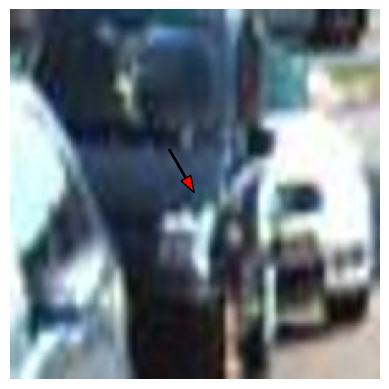

1/1 [==============================] - 0s 39ms/step
330


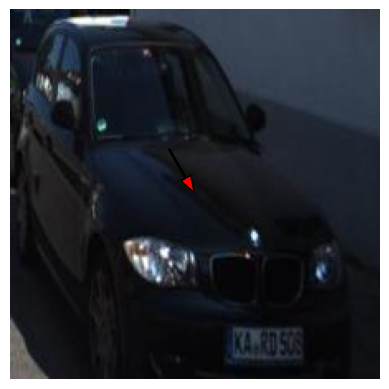

1/1 [==============================] - 0s 36ms/step
330


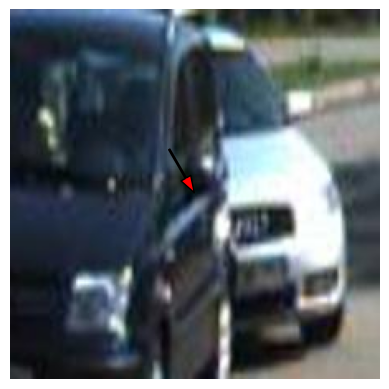

1/1 [==============================] - 0s 35ms/step
330


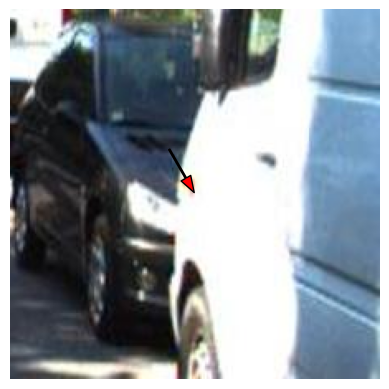

1/1 [==============================] - 0s 43ms/step
330


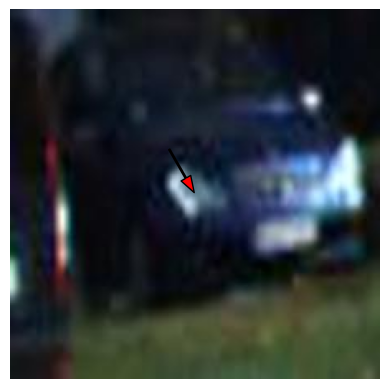

1/1 [==============================] - 0s 22ms/step
330


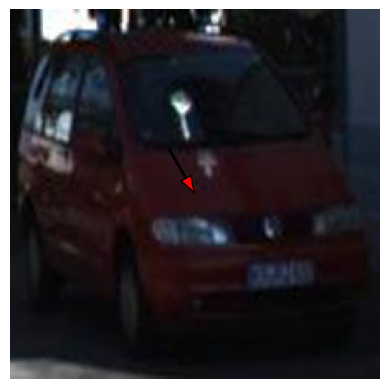

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
import math
import os

class_to_angle = {
    0: 0,
    1: 120,
    2: 150,
    3: 180,
    4: 210,
    5: 240,
    6: 270,
    7: 300,
    8: 30,
    9: 330,
    10: 60,
    11: 90
}


# Load the saved model
model_path = '/content/saved_models/ResNet50_model_exp2.h5'
model = load_model(model_path)

# Define the folder containing the images
folder_path = '/content/preprocessed/330_degrees'

# Function to plot an arrow
def plot_arrow(angle, ax, image_size):
    radians = math.radians(angle-90)  # Subtract from 90 to rotate clockwise with 0 pointing down
    arrow_length = image_size[0] / 2 * 0.3  # 30% of the half of image width
    x_center, y_center = image_size[1] / 2, image_size[0] / 2  # Center of the image
    x_offset, y_offset = arrow_length * math.cos(radians), arrow_length * math.sin(radians)
    ax.annotate('', xy=(x_center, y_center), xytext=(x_center + x_offset, y_center + y_offset),
                arrowprops=dict(facecolor='red', shrink=0.05, width=1, headwidth=8),
                horizontalalignment='center', verticalalignment='center')

# # Iterate over each angle folder
# for folder_name in sorted(os.listdir(folder_path)):
#     full_folder_path = os.path.join(folder_path, folder_name)
#     if os.path.isdir(full_folder_path):
        # Iterate over files in the folder
for image_name in os.listdir(folder_path):
    if image_name.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif')):
        image_path = os.path.join(folder_path, image_name)
        image = load_img(image_path, target_size=(224, 224))
        image_size = image.size  # Save the image size for arrow plotting
        image_array = img_to_array(image)
        image_array = np.expand_dims(image_array, axis=0)

        # Predict the class
        prediction = model.predict(image_array)
        predicted_class = np.argmax(prediction)
        predicted_angle = class_to_angle[predicted_class]  # Map to correct angle
        print(predicted_angle)

        # Plot the original image with the arrow
        fig, ax = plt.subplots()
        ax.imshow(image)
        plot_arrow(predicted_angle, ax, image_size)
        ax.axis('off')  # Hide the axes
        plt.show()  # Show each image one by one
